In [2]:
import pywt
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from scipy import special as sp
from sklearn.metrics import roc_curve

In [3]:
def invqfunc(x):
    return np.sqrt(2)*sp.erfinv(1-2*x)

In [4]:
def plot_roc(roc_df: pd.DataFrame, compare_signals, sensing_window=2):
    plt.figure(figsize=(15, 10))
    pfs = np.arange(0, 1, 0.01)
    for signal in compare_signals:
        snr_db = int(signal.split('_')[0])
        pds = []
        gt_sgn = f'{snr_db}_TX_OFDM'
        sigma = estimate_sigma(df[signal], average_sigmas=True)
        tps_num = len(np.where(roc_df[gt_sgn] > 0)[0])
        for fals_proba in pfs:
            positiv_cases = 0
            window = sensing_window
            for idx in range(0, len(roc_df[signal])):
                if len(roc_df[signal]) - idx <= window:
                    window -= 1
                energy = abs(roc_df.loc[idx:(idx+window), signal])**2
                fin_energy = 1/sensing_window * sum(energy)
                thresh = sigma*(invqfunc(fals_proba))*(np.sqrt(2*window)+window)
                if (fin_energy >= thresh) and (roc_df.loc[idx, gt_sgn] > 0):
                                positiv_cases += 1
            pd = positiv_cases/tps_num
            pds.append(pd)
        plt.plot(pfs, pds, label=signal)
    plt.xlim(0, 1.1)
    plt.plot([0, 1], [0, 1], ls="--", c=".3")
    plt.ylabel('Probability of detection (TP)')
    plt.xlabel('Probability of false alarm (FP)')
    plt.title('Energy Detection - Reciever Operating Characteristics')
    plt.legend()
    plt.show()
    

In [23]:
data_p = r'E:/Faculta/Anul2/Sem1/ACP3/dataset/rx_tx_ofdm.csv'

In [24]:
df = pd.read_csv(data_p)

In [25]:
df.keys()

Index(['-5_TX_OFDM', '-5_RX_OFDM', '0_TX_OFDM', '0_RX_OFDM', '5_TX_OFDM',
       '5_RX_OFDM'],
      dtype='object')

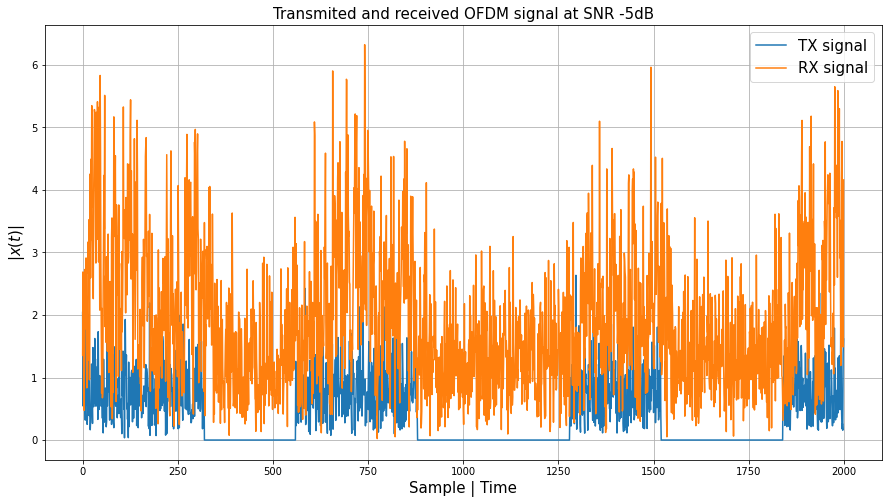

In [10]:
plt.figure(figsize=(15,8))
plt.title(f'Transmited and received OFDM signal at SNR {-5}dB',
         fontsize=15)
plt.plot(df['-5_TX_OFDM'][:2000], label='TX signal')
plt.plot(df['-5_RX_OFDM'][:2000], label='RX signal')
plt.legend(fontsize=10, prop={'size': 15})
plt.xlabel('Sample | Time', fontsize=15); plt.ylabel('$|x(t)|$', fontsize=15);
plt.grid(True);

In [122]:
zeros = df['TX_OFDM'] == 0
ones = df['TX_OFDM'] == 1

In [123]:
df.loc[ones, 'Labels'] = 1
df.loc[zeros, 'Labels'] = 0

In [124]:
cA, cD = pywt.dwt(df['RX_OFDM'], 'db1')

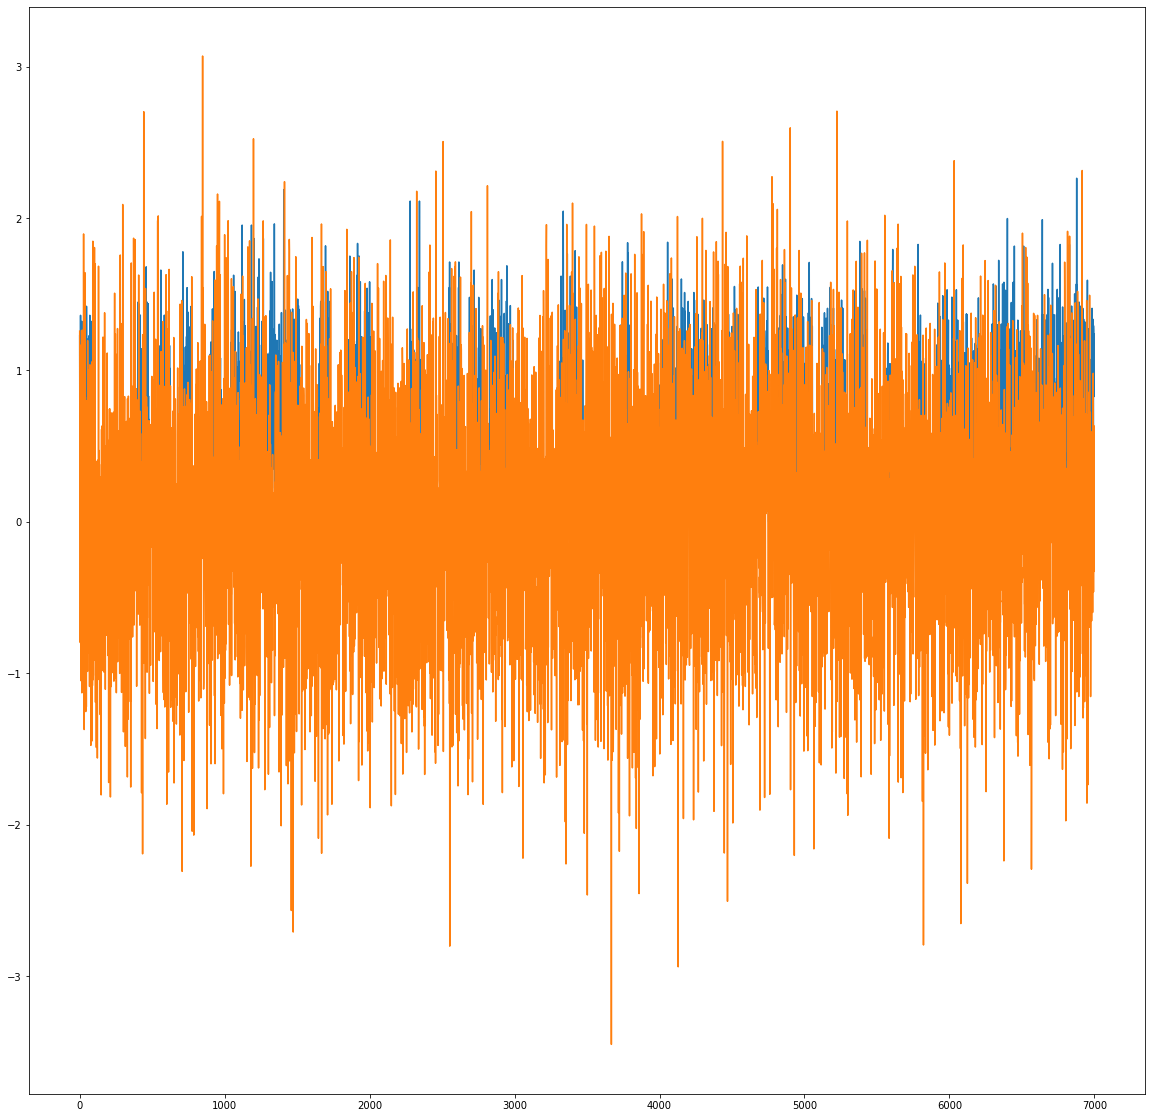

In [125]:
plt.figure(figsize=(20, 20))
plt.plot(df['TX_OFDM'][:7000])
plt.plot(cD[:7000])

In [10]:
sigma_est = estimate_sigma(df['-10_RX_OFDM'], average_sigmas=True)

In [11]:
sigma_est

0.7136758545832431

In [28]:
moc_df = pd.DataFrame()
moc_df['-40_RX_OFDM'] = df['-40_RX_OFDM']

In [115]:
rx_bayes = denoise_wavelet(df['-40_RX_OFDM'], method='BayesShrink', mode='soft',
                           sigma=sigma_est/(1+sigma_est), rescale_sigma=True)
moc_df['-40_BAYES_DENOISED'] = rx_bayes

16000 16000


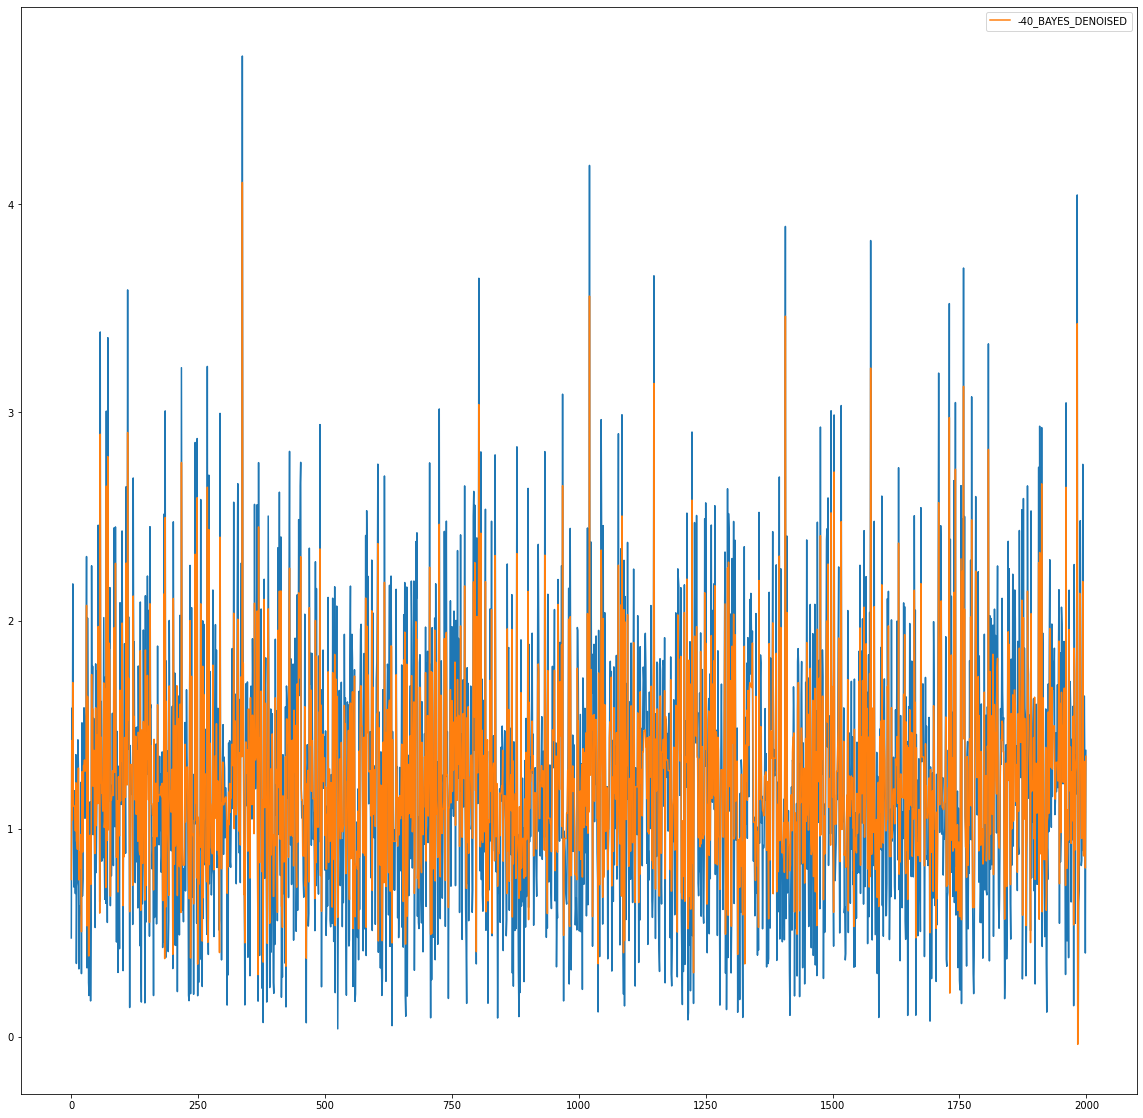

In [116]:
plt.figure(figsize=(20, 20))
plt.plot(df['-40_RX_OFDM'][:2000])
plt.plot(rx_bayes[:2000], label='-40_BAYES_DENOISED')
plt.legend()
print(len(df['-40_TX_OFDM']), len(rx_bayes))

In [82]:
rx_visu = denoise_wavelet(df['-40_RX_OFDM'], method='VisuShrink', mode='soft',
                           sigma=sigma_est/(1+sigma_est*20), rescale_sigma=True)
moc_df['-40_VISU_DENOISED'] = rx_visu

16000 16000


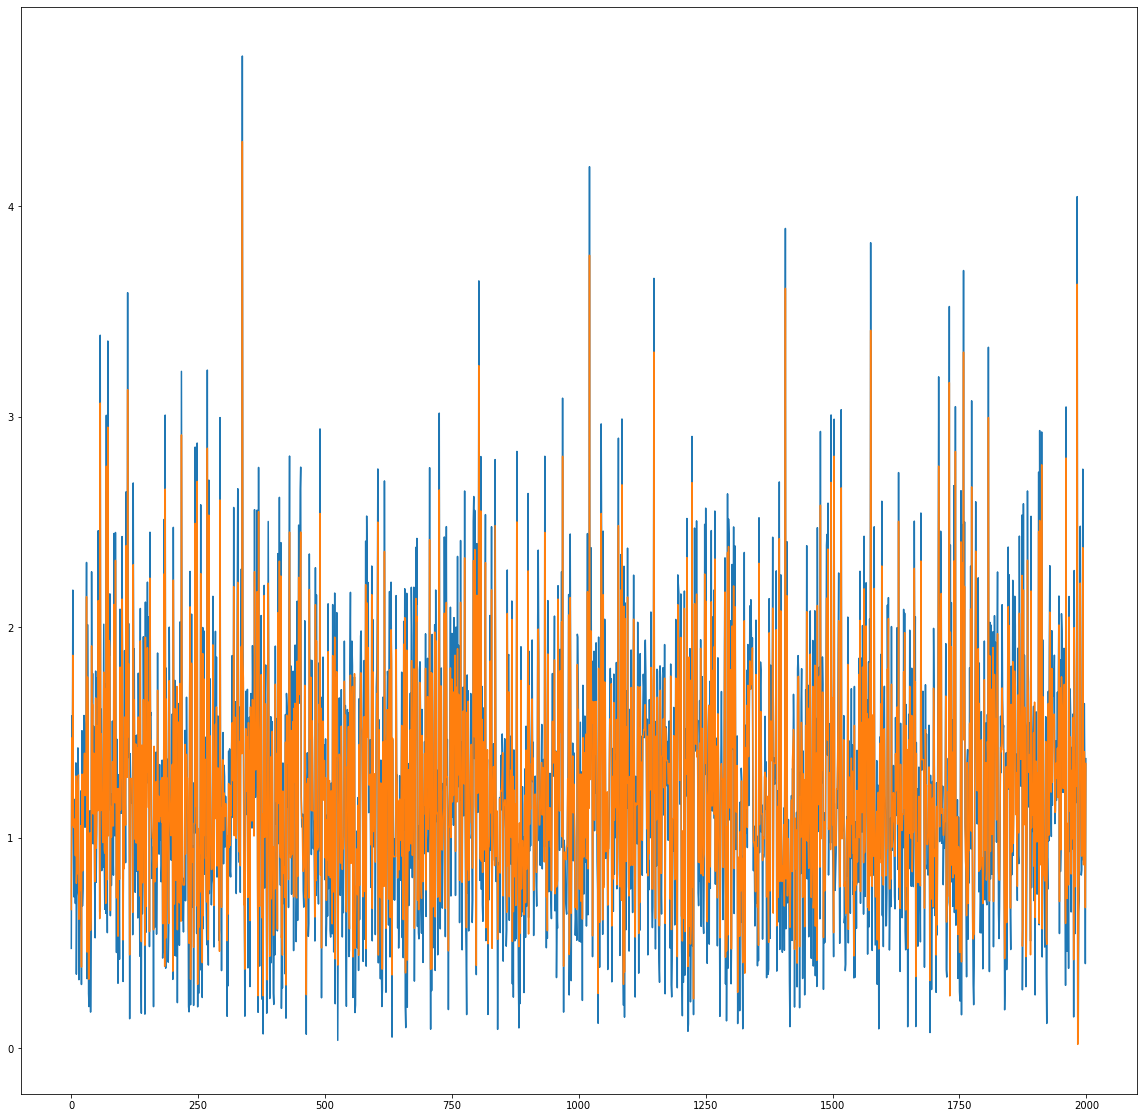

In [83]:
plt.figure(figsize=(20, 20))
plt.plot(df['-40_RX_OFDM'][:2000])
plt.plot(rx_visu[:2000])
print(len(df['-40_RX_OFDM']), len(rx_bayes))

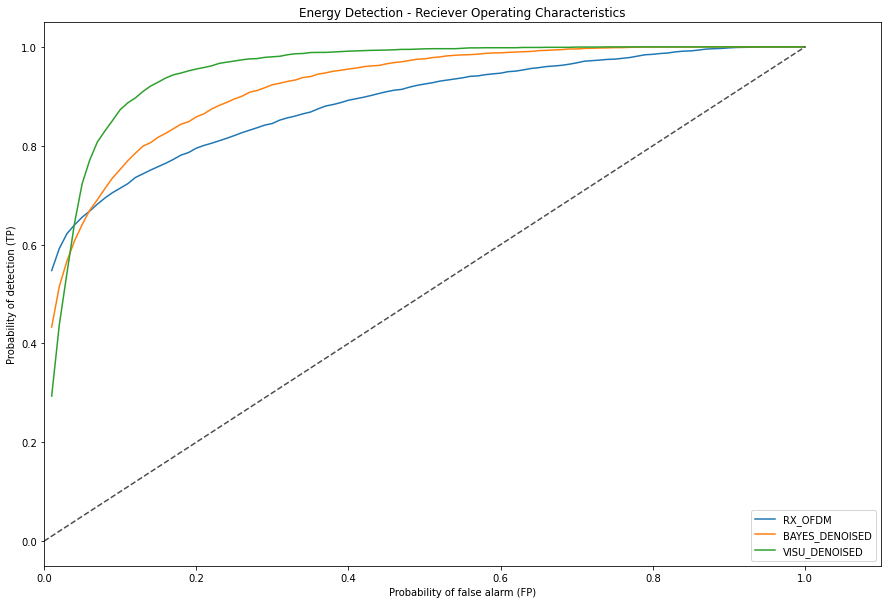

In [187]:
plot_roc(roc_df, snr_db=5, sensing_samples=4)

In [12]:
denoisers = ['BayesShrink', 'VisuShrink']

In [13]:
target_signals = [signal for signal in df if 'RX' in signal]
target_signals

['-20_RX_OFDM', '-10_RX_OFDM']

In [14]:
for sgn in target_signals:
    snrdb = int(sgn.split('_')[0])
    for denoiser in denoisers:
        sigma_est = estimate_sigma(df[sgn], average_sigmas=True)
        if 'VisuShrink' in denoiser:
            ratio = sigma_est * 20
        else:
            ratio = sigma_est
        numi = 1 + ratio
        rx_denoised = denoise_wavelet(df[sgn], method=denoiser, mode='soft',
                           sigma=sigma_est/numi, rescale_sigma=True)
        df[f'{sgn}_{denoiser}'] = rx_denoised


In [15]:
df.to_csv(f'E:/Faculta/Anul2/Sem1/ACP3/dataset/rx_tx_ofdm.csv', index=False)

In [26]:
df.keys()

Index(['-5_TX_OFDM', '-5_RX_OFDM', '0_TX_OFDM', '0_RX_OFDM', '5_TX_OFDM',
       '5_RX_OFDM'],
      dtype='object')

In [27]:
snr_signals = ['-5_RX_OFDM', '0_RX_OFDM', '5_RX_OFDM']
denoising_signals = ['-20_RX_OFDM', '-20_RX_OFDM_BayesShrink', '-20_RX_OFDM_VisuShrink',
                     '-10_RX_OFDM', '-10_RX_OFDM_BayesShrink', '-10_RX_OFDM_VisuShrink']

e:\faculta\anul2\sem1\acp3\.env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
e:\faculta\anul2\sem1\acp3\.env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
e:\faculta\anul2\sem1\acp3\.env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


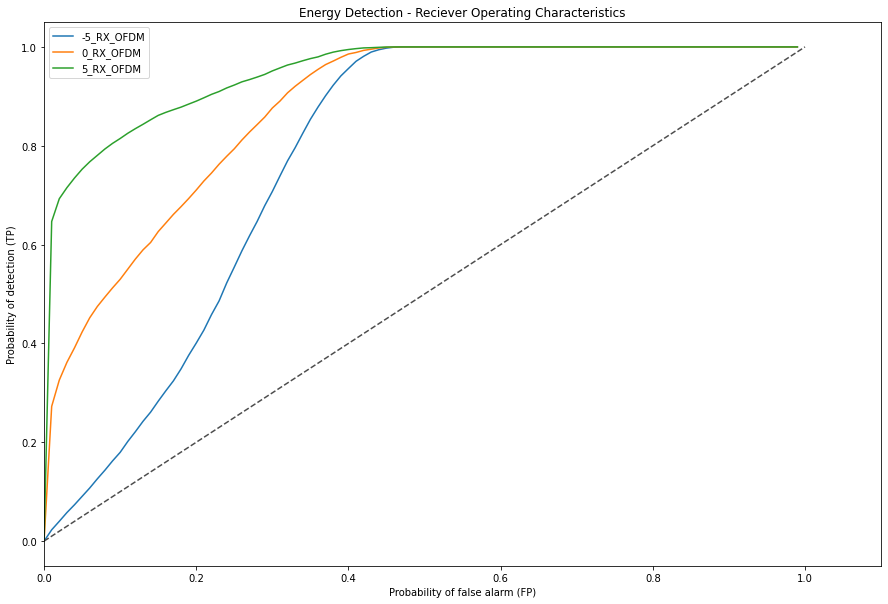

In [28]:
plot_roc(df, sensing_window=5, compare_signals=snr_signals)

e:\faculta\anul2\sem1\acp3\.env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
e:\faculta\anul2\sem1\acp3\.env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
e:\faculta\anul2\sem1\acp3\.env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


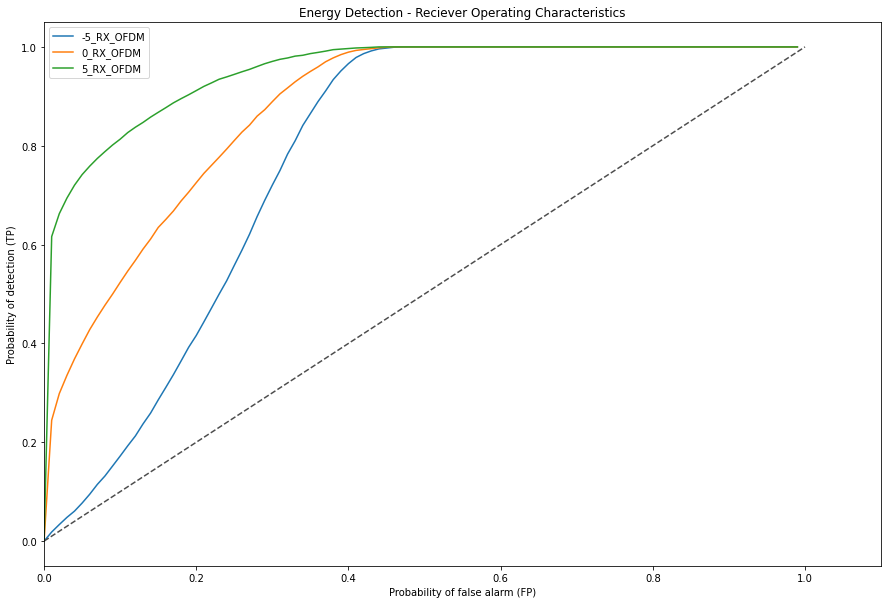

In [27]:
plot_roc(df, sensing_window=5, compare_signals=snr_signals)

e:\faculta\anul2\sem1\acp3\.env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
e:\faculta\anul2\sem1\acp3\.env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
e:\faculta\anul2\sem1\acp3\.env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
e:\faculta\anul2\sem1\acp3\.env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
e:\faculta\anul2\sem1\acp3\.env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
e:\faculta\anul2\sem1\acp3\.env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


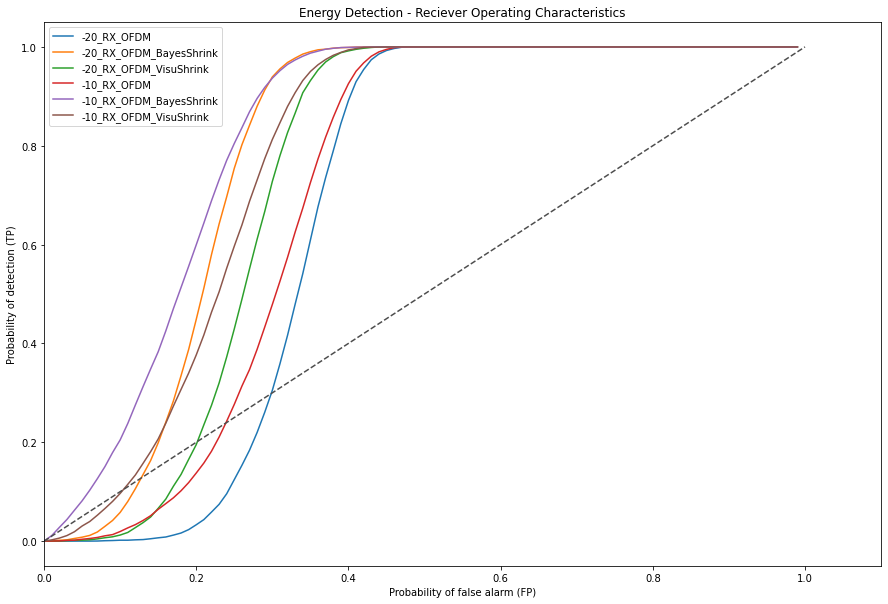

In [19]:
plot_roc(df, sensing_window=5, compare_signals=denoising_signals)